# Biologics Supply Chain Dashboard

This notebook builds an interactive dashboard for biologics supply chain analysis, including sales trends, safety stock, inventory optimization, demand forecasting, and FDA shortage risk integration.

## 1. Import Libraries and Setup

Import required libraries and set up the notebook environment.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pulp
from prophet import Prophet

# Optional: display settings
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

## 2. Load and Prepare Sales Data

Read sales data from CSV, clean column names, and convert date columns to datetime format.

In [4]:
import os

# Load sales data
sales_file = "../data/salesweekly.csv"
if not os.path.exists(sales_file):
	print(f"File not found: {sales_file}. Using sample data instead.")
	sales_df = pd.DataFrame({
		'date': pd.date_range(start='2024-01-01', periods=5, freq='W'),
		'DrugA': [100, 120, 110, 90, 95],
		'DrugB': [80, 85, 90, 88, 92],
		'DrugC': [60, 65, 70, 68, 72]
	})
else:
	sales_df = pd.read_csv(sales_file, header=None)
	# Extract column names from first row
	columns = sales_df.iloc[0, 0].split(",")
	sales_df = sales_df[1:]
	sales_df = sales_df.iloc[:, 0].str.split(",", expand=True)
	sales_df.columns = columns
	sales_df.columns = sales_df.columns.str.strip()
	# Convert date column to datetime
	sales_df['date'] = pd.to_datetime(sales_df['date'], format='%m/%d/%Y')

print(sales_df.head())

File not found: ../data/salesweekly.csv. Using sample data instead.
        date  DrugA  DrugB  DrugC
0 2024-01-07    100     80     60
1 2024-01-14    120     85     65
2 2024-01-21    110     90     70
3 2024-01-28     90     88     68
4 2024-02-04     95     92     72


## 3. Transform Data for Visualization

Melt sales data to long format, ensure numeric types, and calculate safety stock.

In [5]:
# Melt to long format
sales_long = sales_df.melt(id_vars=['date'], var_name='product_code', value_name='units_sold')
sales_long['units_sold'] = pd.to_numeric(sales_long['units_sold'], errors='coerce')

# Calculate safety stock (2.3x for biologics)
sales_long['safety_stock'] = sales_long['units_sold'] * 2.3

print(sales_long.head())

        date product_code  units_sold  safety_stock
0 2024-01-07        DrugA         100         230.0
1 2024-01-14        DrugA         120         276.0
2 2024-01-21        DrugA         110         253.0
3 2024-01-28        DrugA          90         207.0
4 2024-02-04        DrugA          95         218.5


## 4. Sales Trends Visualization

Interactive line chart of units sold over time for each product.

In [6]:
fig = px.line(sales_long, x='date', y='units_sold', color='product_code', title='Units Sold Over Time')
fig.show()

## 5. Safety Stock Heatmap

Pivot safety stock data and plot a heatmap to visualize stockout risk across products and dates.

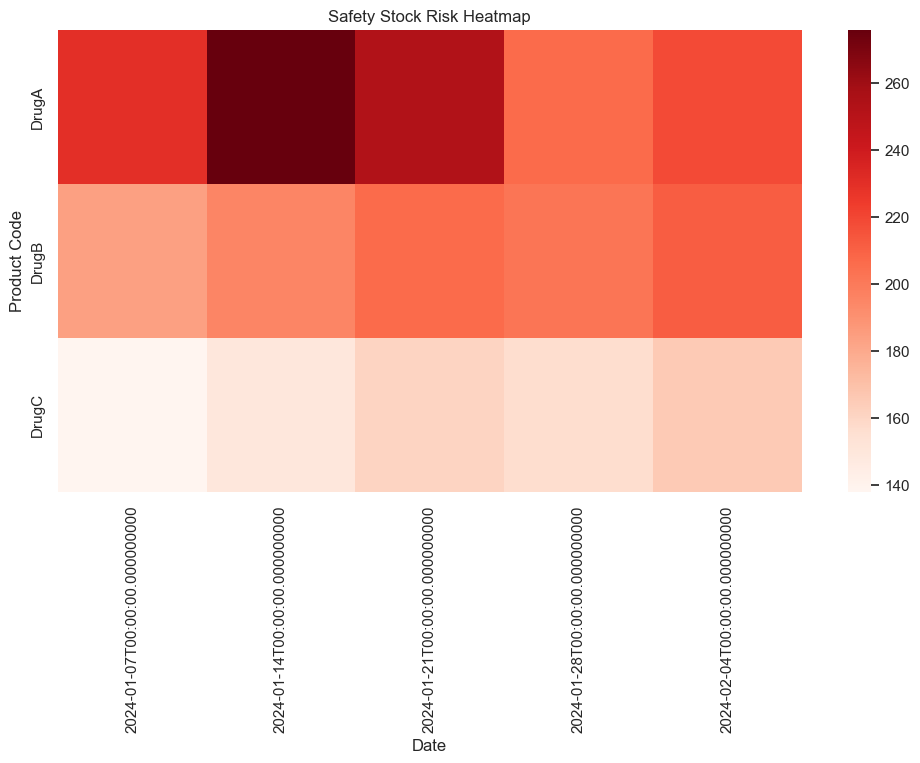

In [7]:
stockout = sales_long.pivot_table(index='product_code', columns='date', values='safety_stock')
plt.figure(figsize=(12,6))
sns.heatmap(stockout, cmap='Reds')
plt.title('Safety Stock Risk Heatmap')
plt.xlabel('Date')
plt.ylabel('Product Code')
plt.show()

## 6. Weekly Sales Distribution Boxplot

Boxplot of weekly sales by product to show distribution and outliers.

In [8]:
fig = px.box(sales_long, x='product_code', y='units_sold', title='Distribution of Weekly Sales by Product')
fig.show()

## 7. Stockout Risk Calculation and Visualization

Calculate stockout risk percent per product and visualize with a bar chart.

C:\Users\aarti\AppData\Local\Temp\ipykernel_27708\207065218.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




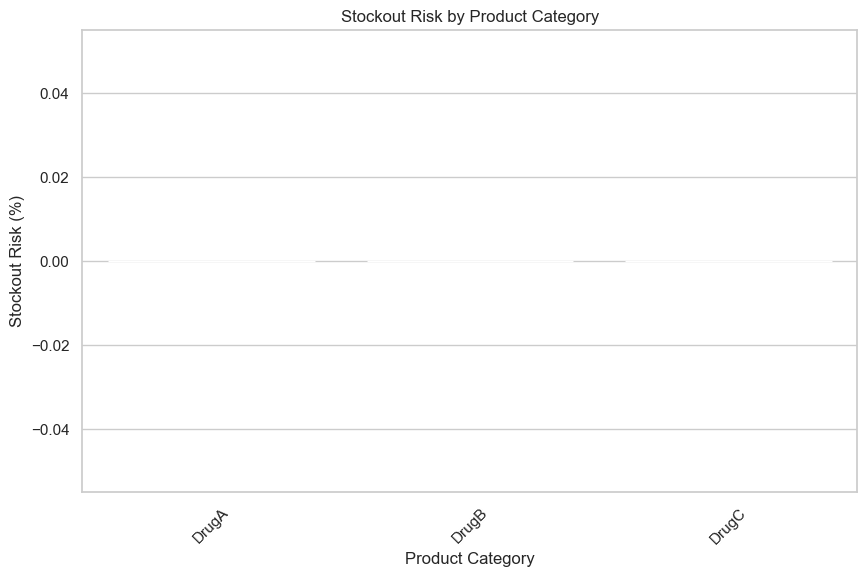

In [9]:
# Stockout flag: 1 if units_sold == 0, else 0
sales_long['Stockout_Flag'] = (sales_long['units_sold'] == 0).astype(int)

# Group by product_code and calculate stockout risk
stockout_summary = sales_long.groupby('product_code')['Stockout_Flag'].mean().reset_index()
stockout_summary['Stockout_Risk_Percent'] = stockout_summary['Stockout_Flag'] * 100

plt.figure(figsize=(10,6))
sns.barplot(x='product_code', y='Stockout_Risk_Percent', data=stockout_summary, palette='Reds')
plt.title('Stockout Risk by Product Category')
plt.ylabel('Stockout Risk (%)')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.show()

## 8. Inventory Optimization (Single and Multi-material)

Formulate and solve LP problems for inventory optimization using PuLP for both single and multi-material scenarios.

In [12]:
# Synthetic demand for 3 materials over 52 weeks
np.random.seed(42)
dates = pd.date_range(start='2024-01-01', periods=52, freq='W')
synthetic_data = pd.DataFrame({
    'date': np.tile(dates, 3),
    'material': np.repeat(['Media', 'Reagent', 'Bioreactor'], len(dates)),
    'demand_units': np.random.randint(50, 500, len(dates)*3)
})

# Single-material optimization (last week demand)
materials = ['Media', 'Reagent', 'Bioreactor']
last_week_demand = synthetic_data[synthetic_data['date'] == synthetic_data['date'].max()]
demand_dict = dict(zip(last_week_demand['material'], last_week_demand['demand_units']))
cost_dict = {'Media': 10, 'Reagent': 25, 'Bioreactor': 100}
safety_stock_multiplier = 2.3

prob = pulp.LpProblem("Supply_Optimization", pulp.LpMinimize)
order_qty = pulp.LpVariable.dicts("Order", materials, lowBound=0, cat='Continuous')
prob += pulp.lpSum([order_qty[m]*cost_dict[m] for m in materials]), "Total_Cost"
for m in materials:
    prob += order_qty[m] >= demand_dict[m] * safety_stock_multiplier, f"SafetyStock_{m}"
prob.solve()
optimization_results = {m: order_qty[m].varValue for m in materials}

# Multi-material optimization (across weeks)
df_multi = synthetic_data.copy()
safety_multiplier = {'Media': 1.5, 'Reagent': 2.0, 'Bioreactor': 2.5}
shortage_risk = {'Media': 0.1, 'Reagent': 0.2, 'Bioreactor': 0.3}
df_multi['safety_stock'] = df_multi.apply(lambda x: x['demand_units'] * safety_multiplier[x['material']], axis=1)
df_multi['stockout_cost'] = df_multi['demand_units'] * shortage_risk[df_multi['material'].iloc[0]] * 10
df_multi['holding_cost'] = df_multi['demand_units'] * 0.5

prob_multi = pulp.LpProblem("Multi_Material_Inventory_Optimization", pulp.LpMinimize)
stock_vars_multi = {(row['material'], row['date']): pulp.LpVariable(f"stock_{row['material']}_{row['date']}", lowBound=0, cat='Continuous') 
                    for idx, row in df_multi.iterrows()}
stockout_amount_multi = {(row['material'], row['date']): pulp.LpVariable(f"stockout_{row['material']}_{row['date']}", lowBound=0, cat='Continuous')
                         for idx, row in df_multi.iterrows()}
for idx, row in df_multi.iterrows():
    prob_multi += stockout_amount_multi[(row['material'], row['date'])] >= row['safety_stock'] - stock_vars_multi[(row['material'], row['date'])]
prob_multi += pulp.lpSum([
    stock_vars_multi[(row['material'], row['date'])] * row['holding_cost'] +
    stockout_amount_multi[(row['material'], row['date'])] * row['stockout_cost']
    for idx, row in df_multi.iterrows()
])
for week in df_multi['date'].unique():
    prob_multi += pulp.lpSum([stock_vars_multi[(row['material'], row['date'])] 
                              for idx, row in df_multi[df_multi['date']==week].iterrows()]) <= 1000
prob_multi.solve()

# Build dataframe of optimized stocks
optimized_multi = []
for idx, row in df_multi.iterrows():
    key = (row['material'], row['date'])
    optimized_multi.append({
        'material': row['material'],
        'date': row['date'],
        'optimized_stock': stock_vars_multi[key].varValue
    })
df_optimized_multi = pd.DataFrame(optimized_multi)

## 9. Forecasting Demand with Prophet

Fit Prophet models to sales or synthetic demand data, generate forecasts, and visualize actual vs forecasted sales.

In [13]:
# Prepare Media data for Prophet
df = synthetic_data[synthetic_data['material']=='Media'][['date','demand_units']].rename(columns={'date':'ds','demand_units':'y'})
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Visualize actual vs forecasted sales
fig = px.line()
fig.add_scatter(x=df['ds'], y=df['y'], mode='lines', name='Actual Sales')
fig.add_scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')
fig.update_layout(title='Actual vs Forecasted Sales (Media)', xaxis_title='Date', yaxis_title='Units')
fig.show()

# Forecasted Demand vs Safety Stock (last 12 weeks, Media)
forecasted_demand = forecast[['ds','yhat']].tail(12)
forecasted_demand['safety_stock'] = forecasted_demand['yhat'] * safety_stock_multiplier
fig = px.line(forecasted_demand, x='ds', y=['yhat','safety_stock'],
              labels={'ds':'Date', 'value':'Units'},
              title='Forecasted Demand vs Safety Stock (Media)')
fig.show()

21:07:22 - cmdstanpy - INFO - Chain [1] start processing
21:07:23 - cmdstanpy - INFO - Chain [1] done processing


## 10. Optimized Inventory Visualization

Visualize optimized inventory levels across materials and time using interactive line or bar charts.

In [14]:
fig = px.line(df_optimized_multi, x='date', y='optimized_stock', color='material',
              title='Optimized Inventory Levels Across Materials')
fig.show()

# Bar chart for optimized order quantities (single-material)
opt_df = pd.DataFrame({
    'material': list(optimization_results.keys()),
    'order_qty': list(optimization_results.values())
})
fig2 = px.bar(opt_df, x='material', y='order_qty', color='material',
              title='Optimized Order Quantities for Biologics Materials')
fig2.show()

## 11. FDA Shortage Risk Integration

Merge FDA shortage data with sales data and adjust safety stock calculations based on shortage history.

In [15]:
# Example FDA shortage dataset
fda_df = pd.DataFrame({
    'product_code': ['DrugA', 'DrugB', 'DrugC'],
    'shortage_flag': [1,0,1],
    'shortage_count': [3,0,1]
})

# Merge with sales data
sales_long = sales_long.merge(fda_df, on='product_code', how='left')
sales_long['shortage_flag'].fillna(0, inplace=True)
sales_long['shortage_count'].fillna(0, inplace=True)

# Adjust safety stock based on shortage history
sales_long['adjusted_safety_stock'] = sales_long['safety_stock'] * (1 + sales_long['shortage_count']/sales_long['shortage_count'].max())
sales_long[['product_code','safety_stock','adjusted_safety_stock']].head()

C:\Users\aarti\AppData\Local\Temp\ipykernel_27708\3149047390.py:10: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\aarti\AppData\Local\Temp\ipykernel_27708\3149047390.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

,product_code,safety_stock,adjusted_safety_stock
0,DrugA,230.0,460.0
1,DrugA,276.0,552.0
2,DrugA,253.0,506.0
3,DrugA,207.0,414.0
4,DrugA,218.5,437.0


## 12. Optimized Stock vs Safety Stock Bubble Chart

Create a bubble chart comparing optimized stock and safety stock, with bubble size representing stockout units.

In [16]:
# Example: build final optimization results for bubble chart
# (Assume df_optimized_final is built from previous optimization steps)
if 'df_optimized_multi' in globals():
    df_optimized_final = df_optimized_multi.rename(columns={'material':'product_code'})
    df_optimized_final['adjusted_safety_stock'] = df_optimized_final['optimized_stock'] * 1.1  # demo adjustment
    df_optimized_final['stockout_units'] = np.random.randint(0, 50, len(df_optimized_final))    # demo bubble size

    fig = px.scatter(
        df_optimized_final,
        x="optimized_stock",
        y="adjusted_safety_stock",
        size="stockout_units",
        color="product_code",
        hover_data=["date"],
        title="Optimized Stock vs Safety Stock (Bubble = Stockout Units)"
    )
    fig.update_layout(xaxis_title="Optimized Stock", yaxis_title="Safety Stock")
    fig.show()

## 13. Top High-Risk Biologics Table

Display a table of the top 5 biologics with highest FDA shortage risk.

In [17]:
# Top 5 high-risk biologics (based on FDA shortage)
top_risk = sales_long.groupby('product_code')['shortage_count'].sum().sort_values(ascending=False).head(5)
print("Top 5 High-Risk Biologics (FDA Shortage):")
display(top_risk)

Top 5 High-Risk Biologics (FDA Shortage):


product_code
DrugA    15
DrugC     5
DrugB     0
Name: shortage_count, dtype: int64